# Model Ensemble

In this notebook, we will make an ensemble of the models we have trained (decision tree, KNN, neural network and Gaussian Naive Bayes classifier) by implementing a voting classifier to improve the prediction performance.


### 1. Data Loading

We first load the training set and the test set (.NPY files).


In [83]:
import numpy as np
xs_test = np.load('data/xs_test.npy')
xs_train = np.load('data/xs_train.npy')
ys_test = np.load('data/ys_test.npy')
ys_train = np.load('data/ys_train.npy')


What's more, the dictionary files (.CSV) are also loaded.


In [84]:
import csv

att_dic = {}
class_dic = {}

# read the .csv files back to the dictionaries
with open('data/att_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        att_dic[row[0]] = row[1]

with open('data/class_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        class_dic[row[0]] = row[1]


### 2. Pre-trained Models Loading

Since in the training process of each model, we have saved the trained model in the "models" folder, now we load them.


In order to load the neural network which was implemented with PyTorch, we have to first re-define the class of the network.


In [85]:
import torch.nn as nn

# a class to define the components of the neural network.


class MLPerceptron(nn.Module):

    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_function):
        super(MLPerceptron, self).__init__()
        # a list of layers
        self.layers = nn.ModuleList()
        # get the size of input layer
        next_hidden_size = input_size
        # define the input and the hidden layers
        for hidden_size in hidden_layer_sizes:
            self.layers.append(nn.Linear(next_hidden_size, hidden_size))
            next_hidden_size = hidden_size
        # define the output layer
        self.output = nn.Linear(next_hidden_size, output_size)
        self.activation_function = activation_function

    # a method to define the forward pass
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
            # the activation function which may work after each layer (except output layer)
            # here the activation function is chosen according to self.activation_function
            if self.activation_function == 'Sigmoid':
                out = torch.sigmoid(out)
            elif self.activation_function == 'ReLU':
                out = torch.relu(out)
            elif self.activation_function == 'Tanh':
                out = torch.tanh(out)
        out = self.output(out)
        return out


For models implemented with scikit-learn package, we use joblib.load() method to load them;

For the model realised with PyTorch (neural network), torch.load() method is used.


In [86]:
import joblib
import torch

nn_clf = torch.load('models/Neural_Network.pth')
tree_clf = joblib.load('models/Decision_Tree.model')
GNB_clf = joblib.load('models/Gaussian_Naive_Bayes.model')
KNN_clf = joblib.load('models/Instance_Based_KNN.model')
SVM_clf = joblib.load('models/Instance_Based_SVM.model')


### 3. Define the Voting Classifier

There is a VotingClassifier() model in the scikit-learn package. However, it only supports to combine the scikit-learn models which are trained on the same training set.

Since we trained the models with data which was pre-processed with different methods (e.g., for KNN, we did normalization.), and the neural network was trained with PyTorch framework, we try to <b>define a voting classifier class by ourselves</b> which can be used to combine any pretrained models implemented with Pytorch or scikit-learn.


The VotingClassifier() we defined has the following two parameters:

- <b>classfiers</b>: A list of pre-trained models to be combined (both sklearn and Pytorch models are accepted).

- <b>voting_mode</b>: A parameter controlling whether to use Hard Voting or Soft Voting.

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;if set as <b>'hard'</b>, it will predict the class with the largest sum of votes from the models;

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;if set as <b>'soft'</b>, it will predict the class with the largest summed probability from the models;


In [87]:
class VotingClassifier():
    # the constructor of the class
    def __init__(self, classifiers, voting_mode):
        # a list which contains the pre-trained models to be ensembled
        self.classifiers = classifiers
        # a parameter controlling whether to use Hard Voting or Soft Voting
        self.voting_mode = voting_mode

    # the method used to predict a set of data
    def predict(self, xs):
        # in order to normalize the data when predicting with neighbors models such as KNN
        # we first calculate the mean value and the standard deviation of the training set
        mu = np.mean(xs_train, axis=0)
        sigma = np.std(xs_train, axis=0)
        xs_normal = (xs-mu)/sigma
        # a list used to store the output value (class)
        ys_output = []

        # if Hard Voting
        if self.voting_mode == 'hard':
            # a np.array which records the prediction results of each model
            ys = np.zeros([xs.shape[0], len(self.classifiers)], dtype=int)

            # for each classifier
            for i, clf in enumerate(self.classifiers):

                # if the classifier is a sklearn model
                if 'sklearn' in str(type(clf)):
                    # for the neighbors models such as KNN, use the normalized data
                    if 'neighbors' in str(type(clf)):
                        ys[:, i] = clf.predict(xs_normal)
                    # for the other model, use the orignal data
                    else:
                        ys[:, i] = clf.predict(xs)

                # if the classifier is a PyTorch model
                else:
                    # convert the data to tensor
                    xs = torch.from_numpy(xs).type(torch.FloatTensor)
                    # predict with the model
                    hat_ys = clf(xs)
                    _, hat_ys = torch.max(hat_ys, 1)
                    ys[:, i] = hat_ys.numpy()

            # for each line of ys
            for y in ys:
                # record the class with the largest sum of votes from the models
                ys_output.append(np.argmax(np.bincount(y)))

        # if Soft Voting
        elif self.voting_mode == 'soft':
            # a np.array which records the sum of the probability of each class
            ys = np.zeros([xs.shape[0], 4], dtype=int)

            # for each classifier
            for i, clf in enumerate(self.classifiers):

                # if the classifier is a sklearn model
                if 'sklearn' in str(type(clf)):
                    # for the neighbors models such as KNN, use the normalized data
                    if 'neighbors' in str(type(clf)):
                        # add the probability of each class to the ys array
                        ys = ys + clf.predict_proba(xs_normal)
                    # for the other model, use the orignal data
                    else:
                        # add the probability of each class to the ys array
                        ys = ys + clf.predict_proba(xs)

                # if the classifier is a PyTorch model
                else:
                    xs_torch = torch.from_numpy(xs).type(torch.FloatTensor)
                    net = nn.Softmax(dim=1)
                    hat_ys = net(clf(xs_torch)).detach().numpy()
                    # add the probability of each class to the ys array
                    ys = ys + hat_ys

            # output the class which has the largest summed probability from the models
            for y in ys:
                ys_output.append(np.argmax(y))

        return (ys_output)


### 4. Model Construction and Evaluation

Then we construct two voting classifiers which combine all the models we have trained in both 'soft' mode and 'hard' mode.

<b>N.B. We don't tune the hyperparameters in this section with grid search for we can't do that -- since some of these models were tuned with cross validation and trained on the whole training set, if we do grid search here, we will not have the data for validation. Only if the models were tuned with a fixed validation set can we tune the voting classifier here.</b>


In [88]:
# a soft voting classifier ensembling all the trained models
soft_voting_clf = VotingClassifier(
    [tree_clf, KNN_clf, nn_clf, GNB_clf, SVM_clf], 'soft')

# a hard voting classifier ensembling all the trained models
hard_voting_clf = VotingClassifier(
    [tree_clf, KNN_clf, nn_clf, GNB_clf, SVM_clf], 'hard')


Then, we evaluate both of the two classifiers by making classification reports on the test set for them.


In [89]:
from sklearn.metrics import classification_report

ys_test_pred_soft = soft_voting_clf.predict(xs_test)
ys_test_pred_hard = hard_voting_clf.predict(xs_test)

# print the classfication report
print('Classification Report of the Soft Voting Classifier on the Test set: \n\n',
      classification_report(ys_test, ys_test_pred_soft, digits=4))

# print the classfication report
print('Classification Report of the Hard Voting Classifier on the Test set: \n\n',
      classification_report(ys_test, ys_test_pred_hard, digits=4))


Classification Report of the Soft Voting Classifier on the Test set: 

               precision    recall  f1-score   support

           0     0.9918    1.0000    0.9959       242
           1     0.9868    0.9740    0.9804        77
           2     1.0000    0.9231    0.9600        13
           3     1.0000    1.0000    1.0000        14

    accuracy                         0.9913       346
   macro avg     0.9947    0.9743    0.9841       346
weighted avg     0.9913    0.9913    0.9913       346

Classification Report of the Hard Voting Classifier on the Test set: 

               precision    recall  f1-score   support

           0     0.9798    1.0000    0.9898       242
           1     0.9865    0.9481    0.9669        77
           2     1.0000    0.9231    0.9600        13
           3     1.0000    0.9286    0.9630        14

    accuracy                         0.9827       346
   macro avg     0.9916    0.9499    0.9699       346
weighted avg     0.9828    0.9827    0.98

As what we have done for other models, we also plot the Confusion Matrix Heatmaps for them to better present the classification results.


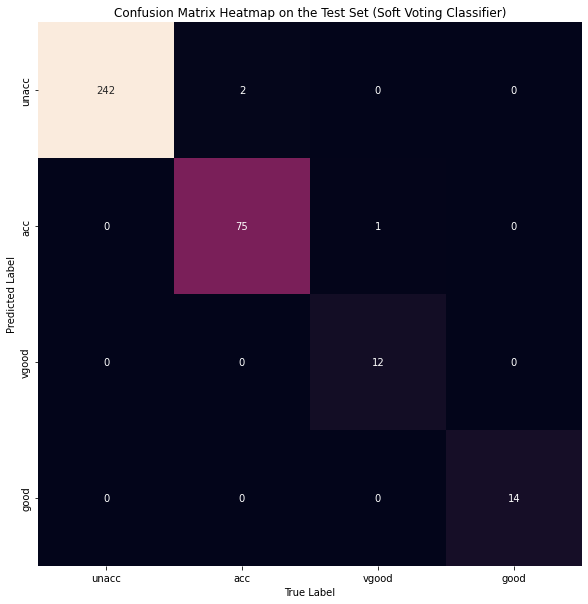

In [90]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# construct a confusion matrix which shows the accuracy on each class
mat_soft = confusion_matrix(ys_test, ys_test_pred_soft)

# plot the confusion matrix into a heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(mat_soft.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_dic.values(), yticklabels=class_dic.values())
# set the x and y label of the figure
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix Heatmap on the Test Set (Soft Voting Classifier)')
plt.show()


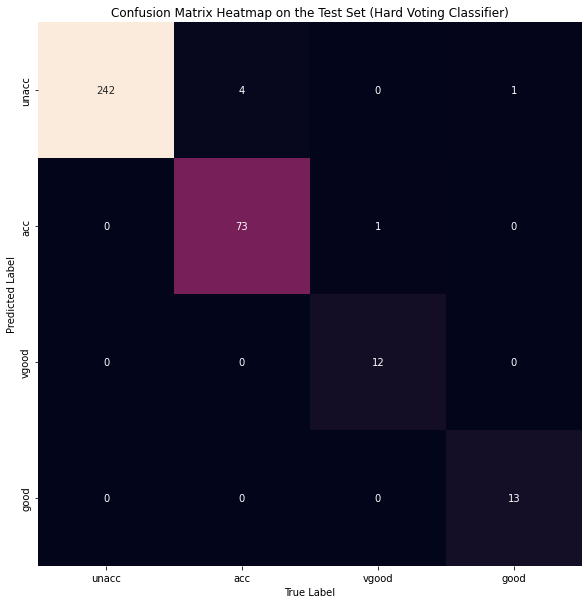

In [91]:
# construct a confusion matrix which shows the accuracy on each class
mat_hard = confusion_matrix(ys_test, ys_test_pred_hard)

# plot the confusion matrix into a heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(mat_hard.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_dic.values(), yticklabels=class_dic.values())
# set the x and y label of the figure
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix Heatmap on the Test Set (Hard Voting Classifier)')
plt.show()


### 4. Model Comparison

Finally, we try to compare the prediction performace of the models on the test set.


First of all, we define a function which can output the prediction performance of different models on the same test set as a list.

In [92]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# a function to output the prediction performance of different models on the same test set
def performance_of_models(models, xs_test, ys_test, metric):

    # in order to normalize the data when predicting with neighbors models such as KNN
    # we first calculate the mean value and the standard deviation of the training set
    mu = np.mean(xs_train, axis=0)
    sigma = np.std(xs_train, axis=0)
    xs_test_normal = (xs_test-mu)/sigma

    # a list to record the weighted F1 scores on each models
    metrics = []

    # set the metric for evaluating the model
    if metric == 'f1':
        evaluate_model = f1_score

    elif metric == 'recall':
        evaluate_model = recall_score
    
    elif metric == 'pre':
        evaluate_model = precision_score

    # for each model
    for model in models:
        # if the classifier is a sklearn model
        if 'sklearn' in str(type(model)) or 'VotingClassifier' in str(type(model)):
            # for the neighbors models such as KNN, use the normalized data
            if 'neighbors' in str(type(model)):
                # append the metric to the metrics list
                ys_test_pred = model.predict(xs_test_normal)
                metrics.append(evaluate_model(
                    ys_test, ys_test_pred, average='weighted'))
            # for the other models, use the orignal data
            else:
                # append the metric to the metrics list
                ys_test_pred = model.predict(xs_test)
                metrics.append(evaluate_model(
                    ys_test, ys_test_pred, average='weighted'))

        # if the classifier is a PyTorch model
        else:
            # convert the data to tensor
            xs = torch.from_numpy(xs_test).type(torch.FloatTensor)
            # predict with the model
            hat_ys = model(xs)
            _, hat_ys = torch.max(hat_ys, 1)
            ys_test_pred = hat_ys.numpy()
            # append the metric to the metrics list
            metrics.append(evaluate_model(
                ys_test, ys_test_pred, average='weighted'))
    return metrics


Then, we use the function to plot a bar chart which shows the weighted F1 score of each models on the test set.

According to the bar chart, the prediction performance of the Gaussian Naive Bayes classifier is much worse than that of others. This may due to the fact that the values of each class in our dataset are not normally distributed, which is against the assumption of the model. 

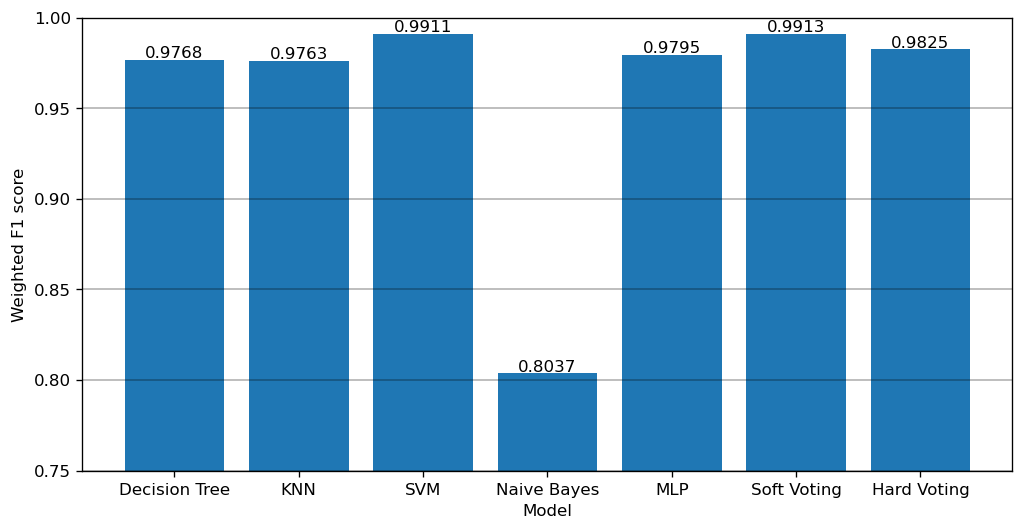

In [93]:

# set the size of the figure
plt.figure(figsize=(10, 5), dpi=120)

# get the F1 score of each model
f1s = performance_of_models([tree_clf, KNN_clf, SVM_clf, GNB_clf, nn_clf,
                            soft_voting_clf, hard_voting_clf], xs_test, ys_test, 'f1')

# set the lable of the bars
labels = ['Decision Tree', 'KNN', 'SVM',
          'Naive Bayes', 'MLP', 'Soft Voting', 'Hard Voting']
plt.grid(color='black',  linewidth=1, axis='y', alpha=0.3)

# plot the bar chart
p2 = plt.bar(range(len(f1s)), f1s)

# show the values on the top of the bars
for x, value in zip(range(len(f1s)), f1s):
    plt.text(x, value+0.001, round(value, 4), ha='center')

# set the xticks as the labels (name of the models)
plt.xticks(range(len(f1s)), labels)
# set the ylim so that the difference can be shown clearly
plt.ylim((0.75, 1))
# set the x and y label of the figure
plt.xlabel('Model')
plt.ylabel('Weighted F1 score')
plt.show()


In order to show the slight difference between the performance of the models clearly, we exclude the Naive Bayes Model, set the ylim from 0.95 to 0.995 and plot the figure again.

According to the bar chart, we can see that the soft voting classifier gets the greatest F1 score, which shows the effect of voting ensemble in improving the prediction performance.

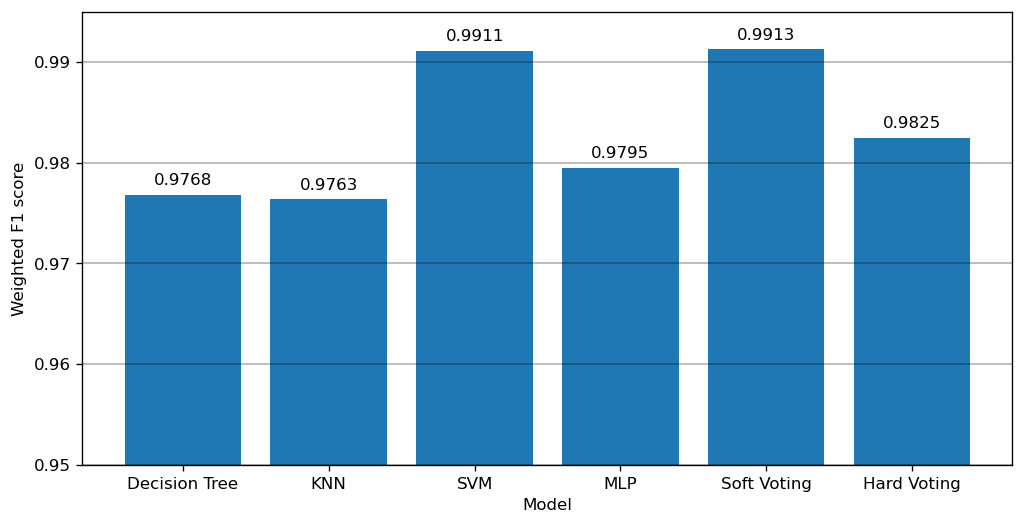

In [94]:

# set the size of the figure
plt.figure(figsize=(10, 5), dpi=120)

# get the F1 score of each model
f1s = performance_of_models([tree_clf, KNN_clf, SVM_clf, nn_clf,
                            soft_voting_clf, hard_voting_clf], xs_test, ys_test, 'f1')

# set the lable of the bars
labels = ['Decision Tree','KNN','SVM','MLP','Soft Voting','Hard Voting']
plt.grid(color='black', linewidth=1, axis='y', alpha=0.3)

# plot the bar chart
p2 = plt.bar(range(len(f1s)), f1s)

# show the values on the top of the bars  
for x,value in zip(range(len(f1s)),f1s):
    plt.text(x,value+0.001,round(value,4),ha='center')

# set the xticks as the labels (name of the models)
plt.xticks(range(len(f1s)),labels)
# set the ylim so that the difference can be shown clearly
plt.ylim((0.95,0.995))
# set the x and y label of the figure   
plt.xlabel('Model')
plt.ylabel('Weighted F1 score')
plt.show()